**Third notebook in analysis** 

**Creates OTU feature table**

In [1]:
import os
from qiime2.plugins import feature_table,alignment, phylogeny, diversity
from qiime2.plugins.vsearch.methods import cluster_features_de_novo
from qiime2.plugins.feature_classifier.methods import classify_sklearn
from qiime2.plugins.taxa.methods import filter_table
from qiime2 import Artifact, Metadata, Visualization
import pandas as pd
from qiime2.plugins.feature_table.methods import filter_samples
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
datapath = '../data'

# QIIME Processing

The feature table, representative sequences, and taxonomy were all calculated separately on the Colby HPC cluster. 

1. Read the feature table, metadata, rep seqs and taxonomy

2. Filter feature table to exclude things not in the metadata

3. Use mafft to align the representative sequences 

4. Use fasttree to make an unrooted tree from the alignment, then midpoint root it 

In [10]:
merged_table = Artifact.load(os.path.join(datapath, 'qiime/merged_table.qza'))
### fix sample ids
mt = merged_table.view(pd.DataFrame)
# make qiime compliant
mt.index = pd.Series(mt.index).apply(lambda x: str(x).replace("-","_"))
# Fix mistakes on 2019 Submission Sheet
mt.index = pd.Series(mt.index).apply(lambda x: 'FJ190628_006' if x == 'Fj190628_006' else x )
mt.index = pd.Series(mt.index).apply(lambda x: 'FJ190827_005' if x == 'FJ190827_005_P3' else x )
mt.index = pd.Series(mt.index).apply(lambda x: 'FJ190827_022' if x == 'FJ190827_005_P4' else x )

# get metadata
bombusMeta = Metadata(pd.read_csv(os.path.join(datapath, 'BombusMetadata.tsv'), 
            sep = '\t').rename(columns = {'Unnamed: 0': 'SampleID'}).set_index('SampleID'))
mt = Artifact.import_data('FeatureTable[Frequency]', mt)
mt = feature_table.methods.filter_samples(table = mt, metadata = bombusMeta).filtered_table
# read in ASVs
rep_seqs = Artifact.load(os.path.join(datapath, 'qiime/merged_rep-seqs.qza'))


/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  series[missing.index] = missing
/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan na

## Collapse ASVs into OTU99s -- **skipping this now**

In [5]:
mt_99, rep_seqs_99 = cluster_features_de_novo(sequences = rep_seqs,
                                table = Artifact.import_data('FeatureTable[Frequency]', mt),
                                perc_identity = .99,threads = 0) 

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --cluster_size /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/tmpl8s4xpgt --id 0.99 --centroids /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/q2-DNAFASTAFormat-cefx5knk --uc /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/tmpjmqq0mmq --qmask none --xsize --threads 0 --minseqlength 1 --fasta_width 0



vsearch v2.21.1_macos_x86_64, 8.0GB RAM, 4 cores
https://github.com/torognes/vsearch

Reading file /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/tmpl8s4xpgt 100%
1349183 nt in 3752 seqs, min 241, max 480, avg 360
Sorting by abundance 100%
Counting k-mers 100%
Clustering 100%
Sorting clusters 100%
Writing clusters 100%
Clusters: 2747 Size min 1, max 27, avg 1.4
Singletons: 2286, 60.9% of seqs, 83.2% of clusters


**filter samples from metadata** (not everything in the table is a unique sample)

In [6]:
mt_99 = feature_table.methods.filter_samples(table = mt_99, metadata = bombusMeta).filtered_table

### how much complexity is lost?

In [14]:
otutable = mt_99.view(pd.DataFrame)
asvtable = mt.loc[otutable.index]
asvtable = asvtable[asvtable.sum()[asvtable.sum() >0].index].copy()

slightly fewer OTUs per sample 

In [50]:
sample_diversity = pd.melt(pd.DataFrame({'asv':(asvtable>0).sum(axis=1),
              'otu':(otutable >0).sum(axis=1)}),  var_name='feature', value_name='sample_richness')

In [59]:
sample_diversity.groupby('feature')['sample_richness'].mean()

feature
asv    25.758621
otu    21.283699
Name: sample_richness, dtype: float64

<AxesSubplot: xlabel='sample_richness', ylabel='Count'>

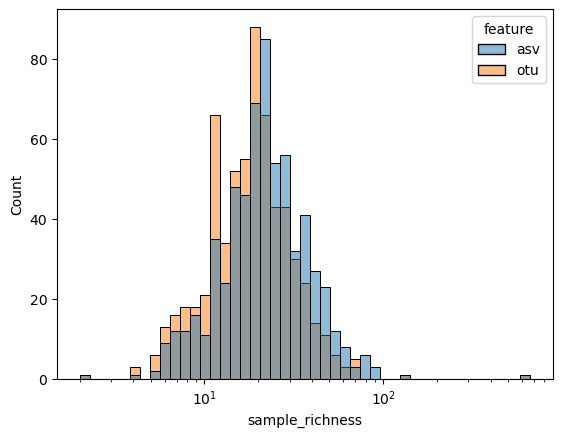

In [55]:
fig, ax = plt.subplots()
plt.xscale('log')
sns.histplot(data = sample_diversity, x='sample_richness', hue = 'feature')

One sample has crazy high OTU diversity! Its also C. bombi positive

In [49]:
bombusMeta.to_dataframe().loc[(asvtable>0).sum(axis=1).sort_values().index[-1]]

species                                   tern
caste                                        W
ID_number                         MY180814-014
date_of_collection                     8/14/18
investigator                                TM
collection_site           Allen Island; Garden
Region                            Allen Island
Latitude                               43.8755
Longitude                             -69.3113
Forage_Plant                               NaN
Temperature                                NaN
Wind                                       NaN
r.H.                                       NaN
H.I.                                       NaN
Time_of_Day                                NaN
date_of_dissection                     8/16/18
date_of_DNA_extraction                10/18/18
Concentration                             15.5
Purity                                    1.94
QPCR_Concentration                        31.3
QPCR_Purity                               1.45
DNA_Storage  

slightly greater prevalence as well

In [58]:
feature_prevalence = pd.melt(pd.DataFrame({'asv':(asvtable>0).sum(axis=0),
              'otu':(otutable >0).sum(axis=0)}),  var_name='feature', value_name='prevalence')
feature_prevalence.groupby('feature')['prevalence'].mean()

feature
asv    4.933654
otu    5.686348
Name: prevalence, dtype: float64

proportion of weird singletons stayed the same

In [67]:
print('asv: ', ((asvtable >0).sum() ==1).sum() / asvtable.shape[1])

print('otu: ', ((otutable >0).sum() ==1).sum() / otutable.shape[1])

asv:  0.763134193935755
otu:  0.7634003350083752


about 1K fewer representative sequences to classify!

In [69]:
print('asv: ', asvtable.shape[1])
print('otu: ', otutable.shape[1])

asv:  3331
otu:  2388


## Try fancy bee taxonomy

**Note**: we didn't post a copy of the classifier to github. Download one from silva to continue

**Note 2**: I downloaded the BEExact full sequences and built a v6v8 classifier

homebrew v6:v8 -- not that great

In [18]:
classifier = Artifact.load('../full_database/BEEx_v2023.01.30_V6V8_classifier.qza')
taxa_ASV = classify_sklearn(reads = rep_seqs, classifier = classifier,  n_jobs = -2, 
               confidence = 0.7, read_orientation = 'auto').classification

**full length classifier** (better version)

In [4]:
classifier = Artifact.load('../full_database/BEEx_v2023.01.30___qiime2_naive-bayes-classifier_FL.qza')
taxa_ASV = classify_sklearn(reads = rep_seqs, classifier = classifier,  n_jobs = -2, 
               confidence = 0.7, read_orientation = 'auto').classification


In [11]:
# Calculate proportion of rows with species-level classification
(taxa_ASV.view(pd.DataFrame)['Taxon'].str.contains('c__')).mean()


0.7934434968017058

**greengenes version:**

In [ ]:
classifier_green = Artifact.load('../data/other_classifiers/2022.10.backbone.full-length.nb.sklearn-1.4.2.qza')
green_taxa = classify_sklearn(reads = rep_seqs, classifier = classifier_green,  n_jobs = 0, 
               confidence = 0.7, read_orientation = 'auto').classification
green_taxa = green_taxa.view(pd.DataFrame)

### ensemble classifier
- if not classified by full length, try greengenes

In [453]:
tax_df = taxa_ASV.view(pd.DataFrame).drop(columns = ['Confidence']).copy()
# Split taxonomy string into separate columns
tax_df = tax_df['Taxon'].str.split(';', expand=True).drop(columns = [7])
tax_df.columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
# Clean up the prefix strings
tax_df['Domain'] = tax_df['Domain'].str.replace('d__', '')
tax_df['Phylum'] = tax_df['Phylum'].str.replace('p__', '')
tax_df['Class'] = tax_df['Class'].str.replace('c__', '') 
tax_df['Order'] = tax_df['Order'].str.replace('o__', '')
tax_df['Family'] = tax_df['Family'].str.replace('f__', '')
tax_df['Genus'] = tax_df['Genus'].str.replace('g__', '')
tax_df['Species'] = tax_df['Species'].str.replace('s__', '')


In [454]:
alterations = {}
def compare(id):

    green = green_taxa.loc[id, 'Taxon'].replace('d__', '').replace('p__',
         '').replace('c__', '').replace('o__', '').replace('f__', '').replace('g__',
                 '').replace('s__', '').strip(' ;').split('; ')
    if len(green) > 6:
        green = list(map(lambda x: x.split('_')[0], green[:6])) + [green[6]]
    else:
        green = list(map(lambda x: x.split('_')[0], green))
    if len(green) >1:
        green[1] = green[1].replace('Proteobacteria', 'Pseudomonadota')
        green[1] = green[1].replace('Firmicutes', 'Bacillota')

    if (len(green) > 4) and (green[4]=='Neisseriaceae'):
        green[2]='Betaproteobacteria'
        green[3]='Neisseriales'
    if (len(green) > 4) and (green[4] == 'Saprospiraceae'):
        green[3]= 'Saprospirales'
        green[2] ='Saprospiria'
    if (len(green)> 3):
        if green[3]=='Cytophagales':
            green[2] = 'Cytophagia'
        elif green[3]=='Bdellovibrionales':
            green[2]= 'Oligoflexia'
        elif green[3] == 'Bradymonadales':
            green[2] = 'Deltaproteobacteria'
            green[1]='Desulfobacterota'
    if (len(green) > 4):
        if green[4]== 'Oscillospiraceae':
            green[3] = 'Eubacteriales'
        elif green[4] == 'Halomonadaceae':
            green[3] = 'Oceanospirillales'
        elif green[4] == 'Woeseiaceae':
            green[3] = 'Chromatiales'
        elif green[4] == 'Vibrionaceae':
            green[3] = 'Vibrionales'
        elif green[4] == 'Lachnospiraceae':
            green[3] = 'Eubacteriales'
    if len(green) > 5:
        if green[5] == 'Pantoea':
            green[4] = 'Erwiniaceae' 
        elif green[5] == 'Peredibacter':
            green[4] = 'Bacteriovoracaceae'
            green[3] =  'Bacteriovoracales'
            green[2] =  'Oligoflexia'
        elif green[5] == 'Lonsdalea':
            green[4] = 'Pectobacteriaceae'
        elif green[5] == 'Udaeobacter':
            green[4] = 'Chthoniobacteraceae'
            green[3] = 'Chthoniobacterales'
            green[2] = 'Spartobacteria'
        elif green[5] == 'Acinetobacter':
            green[3] = 'Moraxellales'
        elif green[5] == 'Sodalis':
            green[4] = 'Bruguierivoracaceae'
        elif green[5] == 'Eubacterium':
            green[4] = 'Eubacteriaceae'
            green[3] = 'Eubacteriales'


    green_depth = len(green)
    bee_depth = tax_df.loc[id].dropna().shape[0]
    #return green
    ## if more green classification, check for matches, if all, extend
    if (green_depth > bee_depth) & (green_depth > 1):
        # confirm matching up to depth 
        if " ".join(green[:bee_depth])  == " ".join(tax_df.loc[id, tax_df.columns[:bee_depth]]):
            for i in range(bee_depth, green_depth):
                tax_df.loc[id, tax_df.columns[i]] = green[i]
            alterations[id] = 'match extension'
            return 'extension'

        else:
            # try removing suffixes from greengenes names 
            for i in range(bee_depth):
                if green[i].split('_')[0] != tax_df.loc[id, tax_df.columns[i]]:
                    alterations[id] = 'mismatch'
                    return 'mismatch!'
            # if here, it worked
            for i in range(green_depth):
                tax_df.loc[id, tax_df.columns[i]] = green[i]
            alterations[id] = 'partial match extension'
            return 'partial match'
    else:
        alterations[id] ='match'
        return 'match'


for i in tax_df.index:
    retval = compare(i)




#compare('fff2004d10c69842d7e0013fb207317c')

96% classified to genus-level!

In [455]:
#temp = (mt.view(pd.DataFrame).transpose() / mt.view(pd.DataFrame\
#    ).transpose().sum()).join(tax_df)

temp = (mt.transpose()/mt.sum(axis=1)).join(tax_df)

stats = {c: temp[~temp[c].isna()].drop(columns = temp.columns[-7:]).sum().mean() for c in temp.columns[-6:]}

del temp
stats

{'Phylum': 0.9994344218945426,
 'Class': 0.9994231489772224,
 'Order': 0.9993795383928977,
 'Family': 0.998974763032054,
 'Genus': 0.9635284249921544,
 'Species': 0.42201762934539294}

### Remove bumblebee sequences from table 

**note: this was only an issue with the old classifier. new one doesnt have bee sequences**

pull up features classified as insects

In [16]:
taxa_99.view(pd.DataFrame)[taxa_99.view(pd.DataFrame)['Taxon'].str.contains('sect')]

,Taxon,Confidence
Feature ID,,


Grab the representative sequences

In [46]:
bombus_seqs = pd.DataFrame(rep_seqs_99.view(pd.Series)).join(taxa_99.view(pd.DataFrame\
        )[taxa_99.view(pd.DataFrame)['Taxon'].str.contains('Insec')])
bombus_seqs = bombus_seqs.dropna().copy()
bombus_seqs[0] = bombus_seqs[0].apply(str)

**I used the blastn web app to verify these sequences as matching bombus**
- You can find the app here: https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blastn&BLAST_SPEC=GeoBlast&PAGE_TYPE=BlastSearch
- I used the standard nr database, as well as a version of the database excluding Bombus. All four still hit bee references after the Bombus references were removed. I ran the second round of alignments to control for chimeric host:microbe assemblies. 

Perfect match to multiple bombus

In [38]:
bombus_seqs.loc['adb56f9c8af5f07d15e8a475f2ce03ec', 0]

'GGATTGACAGATTGATAGCTCTTTCTTGATTCGGTGGGTGGTGGTGCATGGCCGTTCTTAGTTGGTGGAGCGATTTGTCTGGTTAATTCCGATAACGAACGAGACTCTAGCCTGCTAAATAGACGTAACTTATGGTATCTCGAAGGCCCCCGGCTTCGGTCGGTGGGTTTTTACTACCAACGTACAAACAAATCTTCTTAGAGGAACAGGCGGCTTCTAGCCGCACGAGATTGAGCAATAACAGGTCTGTGATGCCCTTAGATGTTCTGGGCCGCACGCGCGCTACACTGAAGGAATCAGCGTGTTTTCCCTGGCCGAAAGGCCCGGGTAACCCGCTGAACCTCCTTCGTGCTAGGGATTGGGGCTTGCAATTATTCCCCATGAACGAGGAATTCCCAGTAAGCGCGAGTCATAAGCTCGCGTT'

Multiple bombus as well

In [42]:
bombus_seqs.iloc[1][0]

'AGTTGTTGCGGTTAAAAAGCTCGTAGTTGAATCTGTGTGTCACAGTGTCGGTTCACCGCTCGCGGTGTTTAACTGGCATTATGTGGTACGTCCTATCGGTGGGCTTAGCTCCTCGCGGGCGGTCCAACTAATATCCCATCGCGGTGCTCTTCACTGAGTGTCGAGGTGGGCCGATACGTTTACTTTGAACAAATTAGAGTGCTTAAAGCAGGCTACCTTCGCCTGAATACTGTGTGCATGGAATAATGGAATAGGACCTCGGTTCTATTTTGTTGGTTTTCGGAGCCCCGAGGTAATGATTAATAGGGACAGATGGGGGCATTCGTATTGCGACGTTAGAGGTGAAATTCTTGGATCGTCGCAAGACGGACAGAAGCGAAAGCATTTGCCAAAAATGTTTTCATTAATCAAGAAC'

Perfect match for the ground bee, Andrena sp., 99% PI for bombus. 

In [48]:
bombus_seqs.iloc[2][0]

'GGATTGACAGATTTATAGCTCTTTCTTGATTCGGTGGGTGGTGGTGCATGGCCGTTCTTAGTTGGTGGAGCGATTTGTCTGGTTAATTCCGATAACGAACGAGACTCTAGCCTGCTAAATAGACGTAACTTATGGTATCACGAAGGTCCCCGACTTCGGTCGGTGGGTTTTTACTACCAACGTACAAACAAATCTTCTTAGAGGGACAGGCGGCTTCTAGCCGCACGAGATTGAGCAATAACAGGTCTGTGATGCCCTTAGATGTTCTGGGCCGCACGCGCGCTACACTGAAGGAATCAGCGTGTTTTCCCTGGCCGAAAGGCCCGGGTAACCCGCTGAACCTCCTTCGTGCTAGGGATTGGGGCTTGCAATTATTCCCCATGAACGAGGAATTCCCAGTAAGCGCGAGTCATAAGCTCGCGTT'

Perfect match to Mason bees (Osmia sp.), 97% PI for bombus. 

In [45]:
bombus_seqs.iloc[3][0]

'GGATTGACAGATTGATAGCTCTTTCTTGATTCGGTGGGTGGTGGTGCATGGCCGTTCTTAGTTGGTGGAGCGATTTGTCTGGTTAATTCCGATAACGAACGAGACTCTAGCCTGTTAAATAGACGTAAATTATGGTATCTCGAAGGCCCCCGACTTCGGTCGGTGTGGTTTTTACTACCAACGTACAAACAAATCTTCTTAGAGGGACAAGCGGCTTCTAGTCGCACGAGATTGAGCAATAACAGGTCTGTGATGCCCTTAGATGTTCTGGGCCGCACGCGCGCTACACTGAAGGAATCAACGTGTTTTCCCTGGCCGAAAGGTCCGGGTAACCCGCTGAAACTCCTTCGTGCTAGGGATTGGGGCTTGAAATTATTCCCCATGAACGAGGAATTCCCAGTAAACGCGAGTCATAAGCTCGCGTT'

**There are a few other OTUs classified as Eukaryotic (mostly fungus and plants). Since they're so low abundant, I'm choosing to keep them** 

In [49]:
euk_inds= taxa_99.view(pd.DataFrame)[taxa_99.view(pd.DataFrame)['Taxon'].str.contains('Euk') & \
    (~taxa_99.view(pd.DataFrame)['Taxon'].str.contains('Ins'))].index

print('mean: ', (mt_99.view(pd.DataFrame)[list(set(euk_inds).intersection(set(mt_99.view(pd.DataFrame).columns)))\
].sum(axis=1) / mt_99.view(pd.DataFrame).sum(axis=1)).mean() * 100)

print('max: ', (mt_99.view(pd.DataFrame)[list(set(euk_inds).intersection(set(mt_99.view(pd.DataFrame).columns)))\
].sum(axis=1) / mt_99.view(pd.DataFrame).sum(axis=1)).max() * 100)

mean:  0.02205304345292302
max:  1.1681608258625373


**save the full table for the manuscript**

In [59]:
taxa_99.view(pd.DataFrame).join(mt_99.view(pd.DataFrame).transpose()).to_csv(os.path.join(datapath,
                        'table/OTU_table_full.tsv'), sep = '\t')

**filter the bees out of the table for the rest of the analysis**

In [60]:
mt_99 = filter_table(table = mt_99, taxonomy = taxa_99,
                    exclude = 'd__Eukaryota; p__Arthropoda; c__Insecta').filtered_table

## Save files 
(they took too long to make to do it again!)
- feature table 
- representative sequences 
- taxonomy 

In [385]:
def printline(x):
    cols = tax_df.loc[x].dropna().index
    return ';'.join([str.lower(c[0]) +'__' +tax_df.loc[x, c] for c in cols])

#list(map(printline, tax_df. index))


In [456]:
ft = pd.DataFrame(tax_df.apply(lambda x: printline(x.name), axis=1),
             columns = ['Taxon']).join(mt.transpose()).dropna()

In [457]:
ft.to_csv(os.path.join(datapath,
                        'table/OTU_table_full.tsv'), sep = '\t')
tax_df.to_csv(os.path.join(datapath, 'table/ensemble_taxa.tsv'),
              sep = '\t')
                

In [282]:
mt.save(os.path.join(datapath, 'qiime', 'mt.qza'))
rep_seqs.save(os.path.join(datapath, 'qiime', 'rep_seqs.qza'))
taxa_ASV.save(os.path.join(datapath, 'qiime', 'taxonomy_ASV.qza'))


'../data/qiime/taxonomy_ASV.qza'

In [13]:
beexactclass = Artifact.load(os.path.join(datapath, 'qiime', 'taxonomy_ASV.qza'))

In [30]:
beexactclass.view(pd.DataFrame).rename(columns = {'Taxon': 'BeExact Taxon',
     'Confidence': 'BeExact Confidence'}).join(green_taxa.rename(columns = {'Taxon':'GreenGenes Taxon',
            'Confidence': 'GreenGenes Confidence'})\
     ).join(mt.view(pd.DataFrame).transpose()).fillna(0).to_csv(os.path.join(datapath,'table/all_classification.tsv'), sep = '\t')

## Create a tree

important for diversity stuff

In [202]:
# MSA
mafft_alignment = alignment.methods.mafft(rep_seqs)
# masked
masked_mafft_alignment = alignment.methods.mask(mafft_alignment.alignment)
# tree + root
unrooted_tree = phylogeny.methods.fasttree(masked_mafft_alignment.masked_alignment)
rooted_tree = phylogeny.methods.midpoint_root(unrooted_tree.tree)
# save 
rooted_tree.rooted_tree.save(os.path.join(datapath, 'qiime/rooted_tree.qza'))

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread 1 /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/7aa4e24b-22ac-43e2-b9df-cc94c0e4ee8e/data/dna-sequences.fasta



inputfile = orig
3752 x 480 - 241 d
nthread = 1
nthreadpair = 1
nthreadtb = 1
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 3701 / 3752 (thread    0)
done.

Constructing a UPGMA tree (efffree=0) ... 
 3750 / 3752
done.

Progressive alignment 1/2... 
STEP  3301 / 3751 (thread    0)
Reallocating..done. *alloclen = 1980
STEP  3701 / 3751 (thread    0)
Reallocating..done. *alloclen = 3120

done.

Making a distance matrix from msa.. 
 3700 / 3752 (thread    0)
done.

Constructing a UPGMA tree (efffree=1) ... 
 3750 / 3752
done.

Progressive alignment 2/2... 
STEP  3501 / 3751 (thread    0)
Reallocating..done. *alloclen = 1989
STEP  3701 / 3751 (thread    0)
Reallocating..done. *alloclen = 3192

done.

disttbfast (nuc) Version 7.526
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
1 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (gu

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: FastTree -quote -nt /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/35744a33-6113-4fe1-be37-fff1c1cc264c/data/aligned-dna-sequences.fasta



FastTree Version 2.1.11 Double precision (No SSE3)
Alignment: /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/35744a33-6113-4fe1-be37-fff1c1cc264c/data/aligned-dna-sequences.fasta
Nucleotide distances: Jukes-Cantor Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jukes-Cantor, CAT approximation with 20 rate categories
      0.54 seconds: Top hits for    938 of   3626 seqs (at seed    100)
      0.75 seconds: Top hits for   1291 of   3626 seqs (at seed    200)
      0.93 seconds: Top hits for   1695 of   3626 seqs (at seed    300)
      1.14 seconds: Top hits for   2133 of   3626 seqs (at seed    400)
      1.26 seconds: Top hits for   2328 of   3626 seqs (at seed    600)
      1.38 seconds: Top hits for   2578 of   3626 seqs (at seed    700)
      1.49 seconds: Top hits for   2697 of   3626 seqs (at seed    900)
      1.60 seconds: Top hits for   2827 of   362

'../data/qiime/rooted_tree.qza'

## Create a rarefied table 

In [203]:
mt = Artifact.load(os.path.join(datapath, 'qiime', 'mt.qza'))
rooted_tree=Artifact.load(os.path.join(datapath, 'qiime/rooted_tree.qza'))
bombusMeta = Metadata.load(os.path.join(datapath, 'BombusMetadata.tsv'))

In [204]:
rarefaction = diversity.actions.alpha_rarefaction(table = mt,
                                                 max_depth = 15000,
                                                 phylogeny = rooted_tree,
                                                 metadata = bombusMeta)
rarefaction.visualization.save(os.path.join(datapath, 'qiime/rarefaction.qzv'))


/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  series[missing.index] = missing
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/608959b3-3ca9-4f87-9bef-3e2d72cfc220/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-3u5e_wvd



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/skbio/util/_warning.py:60: UserWarning: observed_otus is deprecated as of 0.6.0.
  warn(f"{func.__name__} is deprecated as of {ver}.")
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_dat

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/fbaf84a4-328d-4477-80a9-8492f1285c63/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-zu2l02fl



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/e86f4f80-911e-4e5e-8d5a-b4d5257a1930/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-pxk0_enm



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/eadb9ea9-a4e1-4347-8858-e2103abae071/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-v1rca898



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/cbe89040-6c2b-4129-97f8-7ef63329b1d3/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-_vpfgsyd



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/90fff6d0-5ae5-4ad0-9a07-1834c2681c79/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-dm8v2ak4



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/d7fdec0b-da85-46ce-800e-7d2ea31d72d2/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-56yg2wbk



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/a3b3bb5d-1978-4182-8a7d-abaa0152cb1f/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-5vzpulzs



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/815f1f38-99b0-4e3f-a502-c2cc10b1dfc2/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-r7ydi8r8



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/cb5e2f45-8093-4f8f-832d-7e72a08671e2/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-hz_39vvs



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/91e74895-b0a1-49fc-9fcd-a8d2e8ff6c5c/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-tsshoujg



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/f91a265e-49c1-4a98-88b8-8f576e97c62d/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-jnv03h54



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/55839ea2-74b4-499b-b4d6-ee85eb489a87/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-fj13okh4



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/59d5c4b2-4377-43c7-af1b-200be577ec0e/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-v0o0h0te



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/14eb4cf7-9d45-4e58-be17-fc841098b11d/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-tx6gllko



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/22a94626-08ee-483e-a7c9-0b23065f26b9/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-_pshnum9



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/20a3bf0a-a2d1-47ff-a910-a2afcd1770aa/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-xoepd8t6



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/193493b3-9c1e-4cc4-ab36-ca95dfab8d80/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-aeegcb5o



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/9961c5a2-ce3d-4883-b31a-bf824f3d29ed/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-_ao_fja0



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/3d14c351-aef9-44d5-9e84-b23f38d0fb34/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-ycfoesil



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/b2058c59-c38f-42ed-b5ae-3811505835a3/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-x8mjmexg



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/a84b448e-7738-4aaf-b9a2-2f0a6da904b2/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-7z8hmh2e



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/db6facbf-5d3f-430b-9fc3-bb91a8ebba6c/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-tj8a3516



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/2697354f-b5b8-45ba-a9c6-0c59d92eabb2/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-th2_sxq6



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/e3bf6638-2358-4031-972e-c8c278b40045/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-h31nronb



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/4ec29ea5-6dd1-4e21-9f8b-f87e4d8918c9/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-6qg8i6vi



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/1a755f37-5d7c-450a-b56d-95adc93ec1c3/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-67j15k2a



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/f2f32830-e815-4b9d-8837-ea77b510bb92/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-shwh8bgh



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8cbf02b0-0495-4eb0-915a-a3a6326ec90f/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-bbdiwptz



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/2dd2f44c-94c6-4f06-a6e4-227f5dfc8b74/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-tg5rqmvl



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/d503845a-abce-4765-87f1-204f896844bb/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-114tb6r4



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/9713a809-86e4-4c57-887a-0a3d6f4a885b/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-6blku960



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/beff29d5-e514-4864-8db5-a8bb38bd988b/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-4fmbccw6



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/e4f1999b-b169-4903-af7d-4e24cb1b95e9/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-2zjxcant



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/f3681a3a-29df-48c3-8a4a-68817524c086/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-ui7o8v6k



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/2610f4f6-919c-4982-afbd-05c50213d207/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-cyyt7svt



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/c1d21716-acd8-4a1a-a0c8-efcd61099200/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-cqjvyzxj



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/bfc05bcf-a634-4a6d-8f2c-79d17f26f516/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-_7jm6w1e



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/a8f3766d-e1fc-4f17-961b-4d253b07bcab/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-ybdr_r1l



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8955db0a-7f56-4d8d-8632-aa154362fcac/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-i2h0bhyn



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/5be1166b-aeea-4bc8-adf8-992f3e595f28/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-r267uozk



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/15a9a413-e365-49ea-b60b-bea826e38f5b/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-nbflanxy



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/a54c723c-2873-45c8-a293-9b8efac68899/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-b0rw97_x



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/e83fdc9d-c8f1-4634-8e3e-430027d28634/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-8ig3fstv



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/a1e6e0d2-551a-4a1c-82b6-d762698843c9/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-h253zhth



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/37745174-8162-49e8-987c-3682998d02f9/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-xws5r2d9



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/36bdd25b-2ecd-40ab-b469-98e6485b68cf/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-d1wan8pg



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/583d7494-84d2-447f-9b23-855afbd5e798/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-nyn00ldd



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/48735278-82c4-4814-a70d-8e0ec6d7801c/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-mv5atoss



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/04b84668-fc95-4ba8-b4e7-4e9ef17953f8/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-dsnfeumz



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/e5acecff-a0f5-4cbf-ac2e-b6acc6f18d48/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-5ylznwue



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/ef5ecd99-3706-4d78-9199-2adac40db93c/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-p_1cohf9



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/bbc7297d-0286-4678-87bb-8a4b224b557f/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-0byno1fm



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/2183bd6f-3dd6-480b-93d2-ec58da7ecb23/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-mshp4f8q



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/41a24795-749a-477b-b1f4-516101e8acc5/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-um8e5wb5



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/97ee162c-fab0-4686-838c-e6c5958bf624/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-y6dzsu_c



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/871c36f8-9c59-4fa9-bb3e-83f4d64c99ad/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-1txg2c0h



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/a49d9805-bb98-48dd-9671-0697b23170c3/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-zvsgr_uy



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/534efdaa-669c-4ede-a2ca-dcc351d3700e/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-zdlgl97b



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/7f769bf3-127e-4970-b680-b4277b173856/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-qm6s8uls



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/db8ba6dd-fe55-452a-98a5-abbe1835695e/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-clm42yrh



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/0c3383ca-8689-4efe-a997-cb87495a570c/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-qx216h1w



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/26d1c73f-272c-49b0-8ab9-a816e1d907ee/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-3gwmua1a



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/b2180bf3-5401-4a95-ad5d-b75a465601df/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-3cou7o0h



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/188f58e9-568d-4102-99e6-6c630b939933/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-npq2la47



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/ba2903b4-ba1f-493a-bf0b-f27b30225914/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-se68o79e



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/537937ec-82cf-4850-a43b-08e479574215/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-4oh_04eb



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/788f5bb2-d5b7-4d58-b0e3-9dfe7163c3aa/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-93kv39_w



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/faeb3ffb-8e03-4996-9b28-46103fbf8c8f/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-9tprg8xy



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8aa241a8-7428-4d79-ab02-3b88190eb980/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-s_58saao



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/7e4db5c8-9598-4f91-ac6a-c0aeedc74277/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-og7ookcd



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/7f05b5b2-1871-42a2-8341-f7ccf454faa0/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-lzvomnbs



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8fabb232-463c-45da-83dc-19c5b42a1c36/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-0wp2ybco



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/70156eee-47f3-4a09-9eea-16ffdffe9a1c/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-18ft6f3n



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/144c171f-b9cf-4376-b76a-8ba77244a163/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-cmqta6_d



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/59978059-31cb-4949-b03c-03cdbbd8e88d/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-uf81u7_7



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/ee2d33c5-15b1-496b-a299-8992effe0747/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-__5k_3r3



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/79c7261c-61fe-4be3-ac59-7ec25937f739/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-_6d0anyc



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/218f7be0-8765-4493-bdc3-dac26e59a6c5/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-ppwsbnu_



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/abdf01cf-e0f3-4316-b73d-65ca612e19ab/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-qo7pzloz



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/5b00f396-b3d2-4f20-b5ff-af01208a6a20/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-0bhlvo8b



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/431d505a-136f-4d2d-8dc1-401381a109cb/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-5ozwe44f



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/522a1640-2613-4bb2-bf57-9eb0f9f35e8d/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-1qiov70j



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/813d544e-39b8-44ed-8c5a-32264ec568d2/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-xph7qw9i



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/0fb7843f-140a-4786-a06c-d210994f7900/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-iqaz0md1



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/7f71fd26-158b-4159-a4d7-dba7795335c6/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-48l71rmn



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/576d5347-2504-4aeb-b671-388aa2343866/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-w0w9z4ts



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/987bb8a4-2cf2-404b-94b1-744e0ff39e10/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-akcslc7o



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/b6dda065-5def-4bcb-a7f6-9a57fe015e9b/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-zk11qqxa



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/2bf513fc-44b1-460a-8bb2-4142917eb7ca/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-pkt6oakq



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/eea97826-98af-4b0c-8566-d98252aee30a/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-9e_7h_02



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/b55c0d3b-1fb1-4ca9-849c-190e30ef3603/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-5w1x18vb



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/a3319b61-1cd2-48b8-9ef4-ccd45caa1c81/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-a8i7grn0



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/d83fa656-a18b-4ac0-b94b-99c2c7873b90/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-p0rgi_2l



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/539d7055-3922-4621-acec-7cbfc383c723/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-b493begc



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/0b125cbd-b5d7-4ca8-9a85-aec3d7b2aaa9/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-25e90phe



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/51f57bcc-9ef8-4446-8318-51f042b31e4a/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-orwfyzka



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/510e0d94-1a7b-4a90-80f0-40c3db0cab7a/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-0phhg_7o



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/b8a2e93b-8294-48eb-b9d0-a4b1e5ab6489/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-hy08vnbl



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/bed5aabf-10c3-4547-b2ca-f75a2ce0b275/data/feature-table.biom -t /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/data/8ff07e13-3177-4748-b216-aa4b3d591051/data/tree.nwk -o /var/folders/kk/vx23v0b52wv0sx4vqhls42dw0000gn/T/qiime2/Mark/processes/28745-1733069495.838095@Mark/tmp/q2-OutPath-xs3e329h



/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[co

'../data/qiime/rarefaction.qzv'

**4k looks good**
- shannon plateaus, total features still increases for a bit, but assuming that theyre fringe otus

In [225]:
print(rarefaction.result())

<visualization: Visualization uuid: 10fda7ff-003d-44db-bf3c-13482f546660>


In [206]:
rarefaction = Visualization.load(os.path.join(datapath, 'qiime/rarefaction.qzv'))
rarefaction

<visualization: Visualization uuid: 10fda7ff-003d-44db-bf3c-13482f546660>

In [222]:
rarefaction

<visualization: Visualization uuid: 10fda7ff-003d-44db-bf3c-13482f546660>

In [231]:
mt_rare = feature_table.methods.rarefy(table = mt,
                                          sampling_depth = 4000)

In [232]:
mt_rare.rarefied_table.view(pd.DataFrame).shape

(631, 2216)

In [233]:
mt.view(pd.DataFrame).shape

(638, 3331)

In [234]:
mt_rare.rarefied_table.save(os.path.join(datapath, 'qiime', 'mt_rare.qza'))

'../data/qiime/mt_rare.qza'

## Create level-6 and level-3 taxonomy tables

for genus and class-level DA testing later on

In [447]:
mt = Artifact.load(os.path.join(datapath, 'qiime', 'mt.qza')).view(pd.DataFrame)
ft = pd.read_csv(os.path.join(datapath,
                        'table/OTU_table_full.tsv'), sep = '\t', index_col = 0)

Homebrew taxonomy -> homebrew collapse methods

In [458]:
def collapse(level):
    collapsed = ft.copy()
    delim = ';' + str.lower(level[0]) + '__'
    collapsed['Taxon'] = collapsed['Taxon'].apply(lambda x: x.split(delim))
    ## len == 1: not classified to level
    collapsed['Taxon'] = collapsed['Taxon'].apply(lambda x: x[0] if len(x)==1 else \
                                            x[0] + delim + x[1].split(';')[0])
    collapsed= collapsed.groupby('Taxon').sum()
    return collapsed

collapse('Class').to_csv(os.path.join(datapath,
                        'table/class_table.tsv'), sep = '\t')
collapse('Genus').to_csv(os.path.join(datapath,
                        'table/genus_table.tsv'), sep = '\t')

In [452]:
green_taxa[green_taxa['Taxon'].str.contains('g__Eubacterium')]['Taxon'].unique()

array(['d__Bacteria; p__Firmicutes_A; c__Clostridia_258483; o__Lachnospirales; f__Lachnospiraceae; g__Eubacterium_F; s__Eubacterium_F sp000687695'],
      dtype=object)

In [451]:
taxa_ASV.view(pd.DataFrame)[taxa_ASV.view(pd.DataFrame)['Taxon'\
        ].str.contains('g__Eubacterium')]['Taxon'].unique()

array(['d__Bacteria;p__Bacillota;c__Clostridia;o__Eubacteriales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium_rectale;'],
      dtype=object)

In [463]:
allg = collapse('Phylum').index
pd.Series(list(map(lambda x: x.split(';')[-1], allg))).value_counts().sort_values()[-5:]

p__Pseudomonadota       1
p__Spirochaetota        1
p__Fusobacteriota       1
p__Gemmatimonadota      1
p__Verrucomicrobiota    1
Name: count, dtype: int64

In [429]:
[x for x in collapse('Species').index if 'Bdellovibrionales' in x]

['d__Bacteria;p__Bdellovibrionota;c__Oligoflexia;o__Bdellovibrionales',
 'd__Bacteria;p__Bdellovibrionota;c__Oligoflexia;o__Bdellovibrionales;f__Bdellovibrionaceae;g__Bdellovibrio;s__Bdellovibrio_bacteriovorus']